# Load

## Import library & Config

In [ ]:
import os
import sys
import warnings
sys.path.append(os.path.abspath('..')) 
warnings.filterwarnings("ignore")

In [3]:
from src.utils import load_df, save_df, load_json, compare_ensembles
from src.modeling import get_base_models, run_optuna_weighted_ensemble, run_stacking_ensemble, evaluate_dataset
from src.visualization import visualize_all_models_contribution
from src.preprocessing import get_optimal_preprocessor

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso
)

## Load data & models

In [ ]:
raw_data = load_df("raw_data.csv", "data")
raw_FS_data = load_df("raw_FS_data.csv", "data")
FE_data = load_df("FE_data.csv", "data")
FE_FS_data = load_df("FE_FS_data.csv", "data")

In [6]:
X = raw_FS_data.drop(columns=["SalePrice"])
y = raw_FS_data["SalePrice"].values

### Config

In [ ]:
RANDOM_STATE = 42
config = load_json("optimal_config.json")

In [8]:
config

{'outlier_method': {'Linear_Models': 'iqr',
  'Tree_Models': 'iqr',
  'Special_Models': 'iqr'},
 'imputer_type': {'Linear_Models': 'simple',
  'Tree_Models': 'knn',
  'Special_Models': 'simple'},
 'knn_neighbors': {'Tree_Models': 9, 'Linear_Models': 5, 'Special_Models': 5},
 'input_transform': {'Linear_Models': 'org',
  'Tree_Models': 'log',
  'Special_Models': 'org'},
 'target_transform': {'Linear_Models': 'sqrt',
  'Tree_Models': 'org',
  'Special_Models': 'log'},
 'scaler_type': {'Linear_Models': 'minmax',
  'Tree_Models': 'minmax',
  'Special_Models': 'minmax'},
 'encoder_type': {'Linear_Models': 'target',
  'Tree_Models': 'target',
  'Special_Models': 'target'},
 'target_encoder_smoothing': {'Linear_Models': 100,
  'Special_Models': 100,
  'Tree_Models': 10},
 'poly_features': {'Linear_Models': False,
  'Tree_Models': False,
  'Special_Models': False},
 'multicollinearity': {'Linear_Models': None,
  'Tree_Models': None,
  'Special_Models': None}}

## Models & load params

In [9]:
base_models = get_base_models()

In [ ]:
import ast
tuning_params = load_df("tuned_params_results.csv", "data")

# Gán lại tham số tối ưu
for _, row in tuning_params.iterrows():
    model_name = row["Model"]
    params_str = row["Best_Params"]

    try:
        params = ast.literal_eval(params_str)  # 👉 chuyển string sang dict
    except Exception as e:
        print(f"❌ Không parse được params cho {model_name}: {e}")
        continue

    if model_name not in base_models:
        print(f"⚠️ {model_name} không có trong base_models, bỏ qua.")
        continue

    model = base_models[model_name]

    # ⚙️ Xử lý riêng cho RANSAC
    if model_name == "RANSAC":
        # Nếu file lưu có chứa 'estimator' -> xác định base estimator
        est_type = params.pop("estimator", None)
        if est_type == "Ridge":
            base_est = Ridge(alpha=params.pop("alpha_ridge", 1.0))
        elif est_type == "Lasso":
            base_est = Lasso(alpha=params.pop("alpha_lasso", 0.1))
        else:
            base_est = LinearRegression()

        # Gán lại estimator và các tham số còn lại
        model.set_params(estimator=base_est, **params)
        print(f"✅ Đã gán params cho RANSAC (base={est_type})")

    else:
        # Model thường: chỉ cần set_params trực tiếp
        if isinstance(params, dict):
            model.set_params(**params)
            print(f"✅ Đã gán params cho {model_name}")
        else:
            print(f"⚠️ Params cho {model_name} không hợp lệ: {params}")

In [11]:
model_groups = {
    'Linear_Models': ['Ridge', 'Lasso', 'ElasticNet', 'Huber', 'Quantile'],
    'Tree_Models': ['RF', 'XGB', 'GB', 'LGBM', 'ADB'],
    'Special_Models': ['CatBoost', 'RANSAC']
}

# Function for experience

## Final evalution for each dataset

In [ ]:
def final_evalution(df, dataset_name, base_models, model_groups,
                    config, group=None, n_splits=5):
    results_final = []

    print(f"\n{'='*100}")
    print(f"  FINAL EVALUATION VỚI CONFIG TỐI ƯU")
    print(f"{'='*100}")

    for group in model_groups.keys():
        print(f"\n→ Running {group}...")
        res = evaluate_dataset(
            df=df,
            dataset_name=dataset_name,
            base_models=base_models,
            model_groups=model_groups,
            group_name=group,
            n_splits=5,
            knn_neighbors=config["knn_neighbors"].get(group, 5),
            target_encoder_smoothing=config["target_encoder_smoothing"].get(group, 10)
        )
        res["Experiment"] = "Final"
        results_final.append(res)

    # Gộp kết quả
    final_results = pd.concat(results_final, ignore_index=True)

    # Tổng hợp RMSE, R² theo nhóm và model
    print("\n" + "="*70)
    print("           KẾT QUẢ FINAL EVALUATION")
    print("="*70)
    print(final_results[['Group', 'Model', 'Mean_RMSE', 'Std_RMSE', 'Mean_R2']].round(3))

    # Tìm model tốt nhất mỗi nhóm
    best_by_group = final_results.loc[final_results.groupby("Group")["Mean_RMSE"].idxmin()]

    print("\n" + "="*70)
    print("           MODEL TỐT NHẤT MỖI NHÓM")
    print("="*70)
    for _, row in best_by_group.iterrows():
        print(f"{row['Group']:<15}: {row['Model']:<12} | RMSE = {row['Mean_RMSE']:.4f} | R² = {row['Mean_R2']:.4f}")

    # Model tốt nhất
    best_model_row = final_results.loc[final_results["Mean_RMSE"].idxmin()]
    best_model = best_model_row["Model"]
    best_group = best_model_row["Group"]
    best_rmse = best_model_row["Mean_RMSE"]

    print(f"Best Single Model: {best_model} ({best_group}) → RMSE = {best_rmse:.5f}")

    # Top 4
    top4 = final_results.nsmallest(4, "Mean_RMSE")[["Group", "Model", "Mean_RMSE"]].copy()
    print("Top 4 models:")
    print(top4)
    top_models = list(zip(top4["Group"], top4["Model"]))

    return final_results, top_models

## Basic Averaging

In [ ]:
from sklearn.ensemble import VotingRegressor
def create_ensemble_models(results_df, base_models, method="simple"):
    """
    Tạo VotingRegressor từ kết quả CV
    method: 'simple' hoặc 'weighted' (dựa trên Mean_RMSE hoặc Mean_R2)
    """
    ensembles = {}

    for group in results_df['Group'].unique():
        group_results = results_df[results_df['Group'] == group]
        model_names = group_results['Model'].tolist()

        if len(model_names) < 2:
            continue  # cần ít nhất 2 mô hình để ensemble

        estimators = [(name, base_models[name]) for name in model_names if name in base_models]

        if method == "simple":
            ensemble = VotingRegressor(estimators)
            ensemble_name = f"{group}_SimpleAvg"

        elif method == "weighted":
            # Trọng số = 1 / Mean_RMSE (càng tốt càng nặng)
            weights = []
            for name in [est[0] for est in estimators]:
                rmse = group_results[group_results['Model'] == name]['Mean_RMSE'].iloc[0]
                weights.append(1 / rmse)
            weights = np.array(weights)
            weights = weights / weights.sum()  # chuẩn hóa
            ensemble = VotingRegressor(estimators, weights=weights)
            ensemble_name = f"{group}_WeightedAvg"

        ensembles[ensemble_name] = ensemble

    # Ensemble toàn bộ (All Models)
    all_results = results_df[results_df['Group'] != 'All']
    if len(all_results) >= 2:
        all_models = all_results['Model'].unique()
        estimators = [(name, base_models[name]) for name in all_models if name in base_models]

        if method == "simple":
            ensembles["All_SimpleAvg"] = VotingRegressor(estimators)
        elif method == "weighted":
            weights = []
            for name in [est[0] for est in estimators]:
                rmse = all_results[all_results['Model'] == name]['Mean_RMSE'].iloc[0]
                weights.append(1 / rmse)
            weights = np.array(weights) / sum(weights)
            ensembles["All_WeightedAvg"] = VotingRegressor(estimators, weights=weights)

    return ensembles

In [ ]:
def run_full_evaluation_with_ensemble(
    df, dataset_name, base_models, model_groups,
    n_splits=5, RANDOM_STATE=RANDOM_STATE
):
    # === B1: Đánh giá các mô hình cơ sở ===
    print("BƯỚC 1: Đánh giá các mô hình cơ sở...")
    results_base = evaluate_dataset(
        df=df,
        dataset_name=dataset_name,
        base_models=base_models,
        model_groups=model_groups,
        group_name=None,
        n_splits=n_splits,
        RANDOM_STATE=RANDOM_STATE
    )

    # === B2: Tạo Ensemble Models ===
    print("\nBƯỚC 2: Tạo Ensemble (Simple & Weighted Averaging)...")
    simple_ensembles = create_ensemble_models(results_base, base_models, method="simple")
    weighted_ensembles = create_ensemble_models(results_base, base_models, method="weighted")

    # Gộp tất cả ensemble
    ensemble_models = {**simple_ensembles, **weighted_ensembles}

    # Tạo model_groups cho ensemble
    ensemble_groups = {
        "Ensemble_Simple": [name for name in simple_ensembles.keys()],
        "Ensemble_Weighted": [name for name in weighted_ensembles.keys()]
    }

    # === B3: Đánh giá Ensemble ===
    print("\nBƯỚC 3: Đánh giá Ensemble...")
    results_ensemble = evaluate_dataset(
        df=df,
        dataset_name=dataset_name,
        base_models=ensemble_models,
        model_groups=ensemble_groups,
        group_name=None,
        n_splits=n_splits,
        RANDOM_STATE=RANDOM_STATE
    )

    # === Gộp kết quả ===
    final_results = pd.concat([results_base, results_ensemble], ignore_index=True)

    # Sắp xếp theo RMSE
    final_results = final_results.sort_values("Mean_RMSE").reset_index(drop=True)

    print("\n" + "="*80)
    print("HOÀN TẤT TOÀN BỘ: CƠ SỞ + SIMPLE AVERAGING + WEIGHTED AVERAGING")
    print("="*80)

    return final_results

# Run Experiments

## Final evaluation after Tuning

In [ ]:
FS_final_results, FS_top_model = final_evalution(raw_FS_data, "FS_data", base_models, model_groups, config)


  FINAL EVALUATION VỚI CONFIG TỐI ƯU

→ Running Linear_Models...

GROUP: Linear_Models | DATASET: FS_data

Model: Ridge
   Fold 1 → RMSE=29705.44, R²=0.8850, Time=0.26s
   Fold 2 → RMSE=26846.19, R²=0.8940, Time=0.12s
   Fold 3 → RMSE=35812.37, R²=0.7679, Time=0.25s
   Fold 4 → RMSE=28113.88, R²=0.8741, Time=0.20s
   Fold 5 → RMSE=21432.30, R²=0.9121, Time=0.46s

Model: Lasso
   Fold 1 → RMSE=29497.61, R²=0.8866, Time=0.37s
   Fold 2 → RMSE=26307.93, R²=0.8982, Time=0.55s
   Fold 3 → RMSE=36412.72, R²=0.7600, Time=0.37s
   Fold 4 → RMSE=27954.59, R²=0.8755, Time=0.18s
   Fold 5 → RMSE=21409.94, R²=0.9123, Time=0.26s

Model: ElasticNet
   Fold 1 → RMSE=29687.69, R²=0.8851, Time=0.16s
   Fold 2 → RMSE=26810.17, R²=0.8943, Time=0.27s
   Fold 3 → RMSE=35885.47, R²=0.7669, Time=0.21s
   Fold 4 → RMSE=28103.30, R²=0.8742, Time=0.22s
   Fold 5 → RMSE=21427.03, R²=0.9122, Time=0.22s

Model: Huber
   Fold 1 → RMSE=28130.30, R²=0.8968, Time=0.71s
   Fold 2 → RMSE=24194.50, R²=0.9139, Time=0.53s

## Basic Simple and Weighted Averaging

In [ ]:
# Giả sử bạn đã có df_train_processed
final_results = run_full_evaluation_with_ensemble(
    df=raw_FS_data,
    dataset_name="FS_data",
    base_models=base_models,
    model_groups=model_groups,
    n_splits=5,
    RANDOM_STATE=42
)

# Xem top 10
print(final_results[['Group', 'Model', 'Mean_RMSE', 'Std_RMSE', 'Mean_R2']].head(10))

BƯỚC 1: Đánh giá các mô hình cơ sở...

GROUP: All | DATASET: FS_data

Model: Ridge
   Fold 1 → RMSE=34551.21, R²=0.8444, Time=0.03s
   Fold 2 → RMSE=34053.46, R²=0.8294, Time=0.04s
   Fold 3 → RMSE=51902.87, R²=0.5124, Time=0.05s
   Fold 4 → RMSE=31163.36, R²=0.8453, Time=0.07s
   Fold 5 → RMSE=25369.88, R²=0.8769, Time=0.04s

Model: Lasso
   Fold 1 → RMSE=34379.69, R²=0.8459, Time=0.15s
   Fold 2 → RMSE=33511.64, R²=0.8348, Time=0.11s
   Fold 3 → RMSE=53443.23, R²=0.4830, Time=0.13s
   Fold 4 → RMSE=31288.72, R²=0.8441, Time=0.15s
   Fold 5 → RMSE=25449.78, R²=0.8761, Time=0.18s

Model: ElasticNet
   Fold 1 → RMSE=34528.99, R²=0.8446, Time=0.14s
   Fold 2 → RMSE=34022.00, R²=0.8298, Time=0.16s
   Fold 3 → RMSE=52002.02, R²=0.5105, Time=0.19s
   Fold 4 → RMSE=31155.83, R²=0.8454, Time=0.16s
   Fold 5 → RMSE=25369.17, R²=0.8769, Time=0.14s

Model: Huber
   Fold 1 → RMSE=32969.81, R²=0.8583, Time=0.11s
   Fold 2 → RMSE=32502.64, R²=0.8446, Time=0.41s
   Fold 3 → RMSE=45824.82, R²=0.6199,

## Advanced Ensemble

### Raw FS Data

**AVERAGING**

In [ ]:
FS_weighted_res, _ = run_optuna_weighted_ensemble(raw_FS_data, "raw_FS_data", base_models, model_groups, config)


→ Running group: Linear_Models
   Training Ridge (target: sqrt)...
      Fold 1 → RMSE=29787.77
      Fold 2 → RMSE=26977.03
      Fold 3 → RMSE=35815.06
      Fold 4 → RMSE=27963.99
      Fold 5 → RMSE=21708.27
   Ridge: Mean RMSE = 28450.42
   Training Lasso (target: sqrt)...
      Fold 1 → RMSE=29544.56
      Fold 2 → RMSE=26372.45
      Fold 3 → RMSE=36417.07
      Fold 4 → RMSE=27815.45
      Fold 5 → RMSE=21674.58
   Lasso: Mean RMSE = 28364.82
   Training ElasticNet (target: sqrt)...
      Fold 1 → RMSE=29768.39
      Fold 2 → RMSE=26938.81
      Fold 3 → RMSE=35888.59
      Fold 4 → RMSE=27953.90
      Fold 5 → RMSE=21703.22
   ElasticNet: Mean RMSE = 28450.58
   Training Huber (target: sqrt)...
      Fold 1 → RMSE=28114.64
      Fold 2 → RMSE=24228.78
      Fold 3 → RMSE=37410.58
      Fold 4 → RMSE=27512.75
      Fold 5 → RMSE=21479.07
   Huber: Mean RMSE = 27749.16
   Training Quantile (target: sqrt)...
      Fold 1 → RMSE=28611.07
      Fold 2 → RMSE=24492.34
      Fold 3 

**STACKING**

In [ ]:
FS_stacking_res, _ = run_stacking_ensemble(raw_FS_data, "raw_FS_data", base_models, model_groups, config)


STACKING - RAW_FS_DATA

→ Running group: Linear_Models
   Training Ridge (target: sqrt)...
      Fold 1 → RMSE=29787.77
      Fold 2 → RMSE=26977.03
      Fold 3 → RMSE=35815.06
      Fold 4 → RMSE=27963.99
      Fold 5 → RMSE=21708.27
   Ridge: Mean RMSE = 28450.42
   Training Lasso (target: sqrt)...
      Fold 1 → RMSE=29544.56
      Fold 2 → RMSE=26372.45
      Fold 3 → RMSE=36417.07
      Fold 4 → RMSE=27815.45
      Fold 5 → RMSE=21674.58
   Lasso: Mean RMSE = 28364.82
   Training ElasticNet (target: sqrt)...
      Fold 1 → RMSE=29768.39
      Fold 2 → RMSE=26938.81
      Fold 3 → RMSE=35888.59
      Fold 4 → RMSE=27953.90
      Fold 5 → RMSE=21703.22
   ElasticNet: Mean RMSE = 28450.58
   Training Huber (target: sqrt)...
      Fold 1 → RMSE=28114.64
      Fold 2 → RMSE=24228.78
      Fold 3 → RMSE=37410.58
      Fold 4 → RMSE=27512.75
      Fold 5 → RMSE=21479.07
   Huber: Mean RMSE = 27749.16
   Training Quantile (target: sqrt)...
      Fold 1 → RMSE=28611.07
      Fold 2 → RMS

**COMPARE RESULTS**


SO SÁNH: BEST SINGLE vs WEIGHTED vs STACKING - RAW_FS_DATA
           Set  Best_Single_RMSE  Weighted_RMSE  Stacking_RMSE
    all_models          25570.53       25295.67       24822.23
   top4_global          25570.53       25292.91       25222.55
top1_per_group          25570.53       25478.37       25366.28


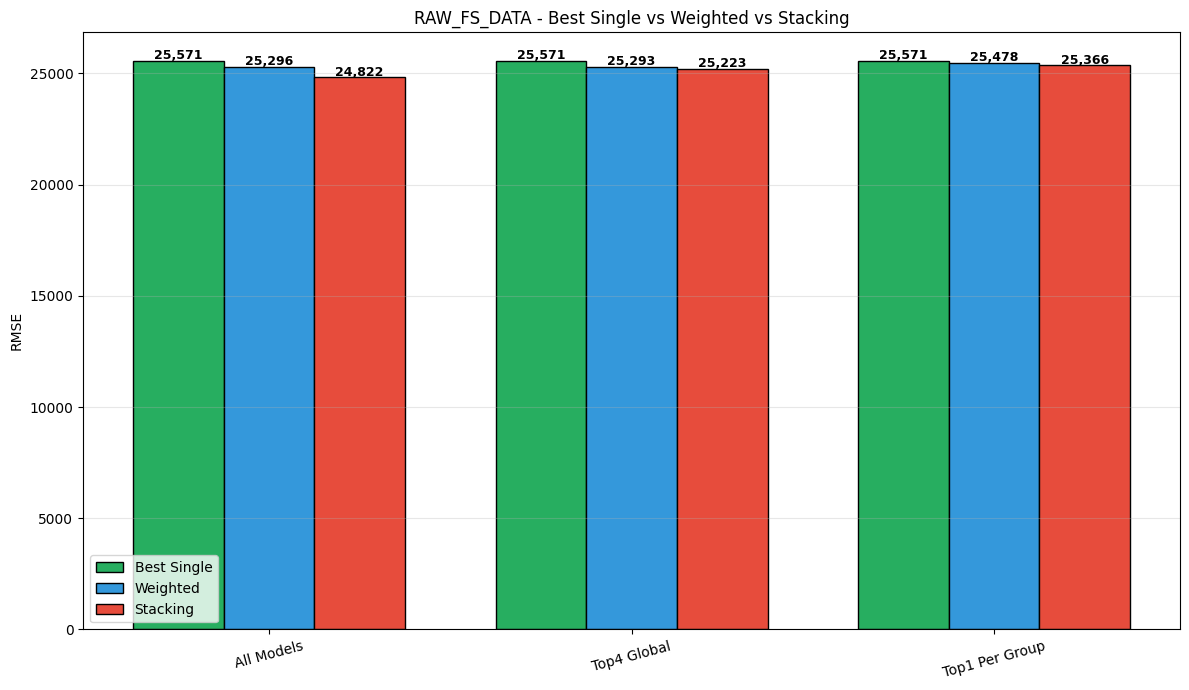

Đã lưu biểu đồ so sánh 3 cột tại:
   results/final_comparison


In [ ]:
compare_ensembles(FS_weighted_res, FS_stacking_res, "raw_FS_data")

### Raw Data

**AVERAGING**

In [ ]:
raw_weighted_res, _ = run_optuna_weighted_ensemble(raw_data, "raw_data", base_models, model_groups, config)


→ Running group: Linear_Models
   Training Ridge (target: sqrt)...
      Fold 1 → RMSE=28006.11
      Fold 2 → RMSE=26417.28
      Fold 3 → RMSE=34921.25
      Fold 4 → RMSE=27109.79
      Fold 5 → RMSE=21771.32
   Ridge: Mean RMSE = 27645.15
   Training Lasso (target: sqrt)...
      Fold 1 → RMSE=27895.13
      Fold 2 → RMSE=25950.40
      Fold 3 → RMSE=35532.67
      Fold 4 → RMSE=26812.25
      Fold 5 → RMSE=21543.83
   Lasso: Mean RMSE = 27546.86
   Training ElasticNet (target: sqrt)...
      Fold 1 → RMSE=27990.32
      Fold 2 → RMSE=26378.11
      Fold 3 → RMSE=34977.54
      Fold 4 → RMSE=27107.93
      Fold 5 → RMSE=21753.65
   ElasticNet: Mean RMSE = 27641.51
   Training Huber (target: sqrt)...
      Fold 1 → RMSE=28617.51
      Fold 2 → RMSE=25539.10
      Fold 3 → RMSE=34645.30
      Fold 4 → RMSE=26835.73
      Fold 5 → RMSE=20645.96
   Huber: Mean RMSE = 27256.72
   Training Quantile (target: sqrt)...
      Fold 1 → RMSE=27642.54
      Fold 2 → RMSE=23862.89
      Fold 3 

**STACKING**

In [ ]:
raw_stacking_res, _ = run_stacking_ensemble(raw_data, "raw_data", base_models, model_groups, config)


STACKING - RAW_DATA

→ Running group: Linear_Models
   Training Ridge (target: sqrt)...
      Fold 1 → RMSE=28006.11
      Fold 2 → RMSE=26417.28
      Fold 3 → RMSE=34921.25
      Fold 4 → RMSE=27109.79
      Fold 5 → RMSE=21771.32
   Ridge: Mean RMSE = 27645.15
   Training Lasso (target: sqrt)...
      Fold 1 → RMSE=27895.13
      Fold 2 → RMSE=25950.40
      Fold 3 → RMSE=35532.67
      Fold 4 → RMSE=26812.25
      Fold 5 → RMSE=21543.83
   Lasso: Mean RMSE = 27546.86
   Training ElasticNet (target: sqrt)...
      Fold 1 → RMSE=27990.32
      Fold 2 → RMSE=26378.11
      Fold 3 → RMSE=34977.54
      Fold 4 → RMSE=27107.93
      Fold 5 → RMSE=21753.65
   ElasticNet: Mean RMSE = 27641.51
   Training Huber (target: sqrt)...
      Fold 1 → RMSE=28617.51
      Fold 2 → RMSE=25539.10
      Fold 3 → RMSE=34645.30
      Fold 4 → RMSE=26835.73
      Fold 5 → RMSE=20645.96
   Huber: Mean RMSE = 27256.72
   Training Quantile (target: sqrt)...
      Fold 1 → RMSE=27642.54
      Fold 2 → RMSE=2

**COMPARE RESULTS**


SO SÁNH: BEST SINGLE vs WEIGHTED vs STACKING - RAW_DATA
           Set  Best_Single_RMSE  Weighted_RMSE  Stacking_RMSE
    all_models          25361.43       25009.71       24230.81
   top4_global          25361.43       25025.40       24578.30
top1_per_group          25361.43       24993.35       24716.78


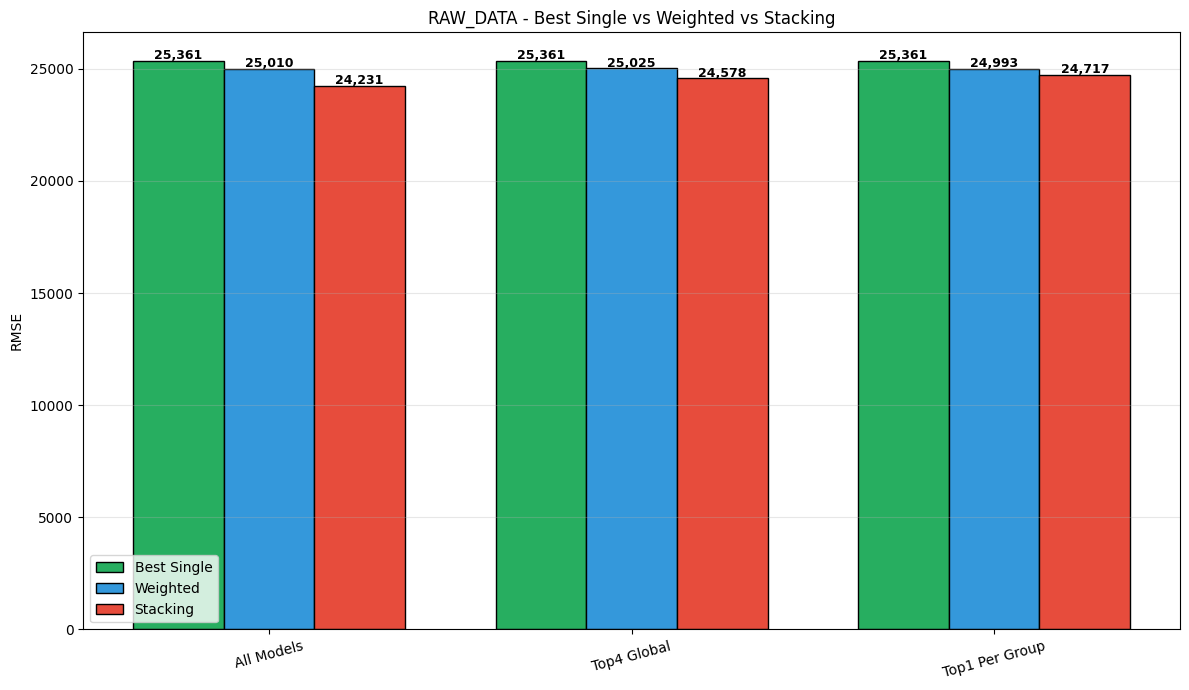

Đã lưu biểu đồ so sánh 3 cột tại:
   results/final_comparison


In [ ]:
compare_ensembles(raw_weighted_res, raw_stacking_res, "raw_data")

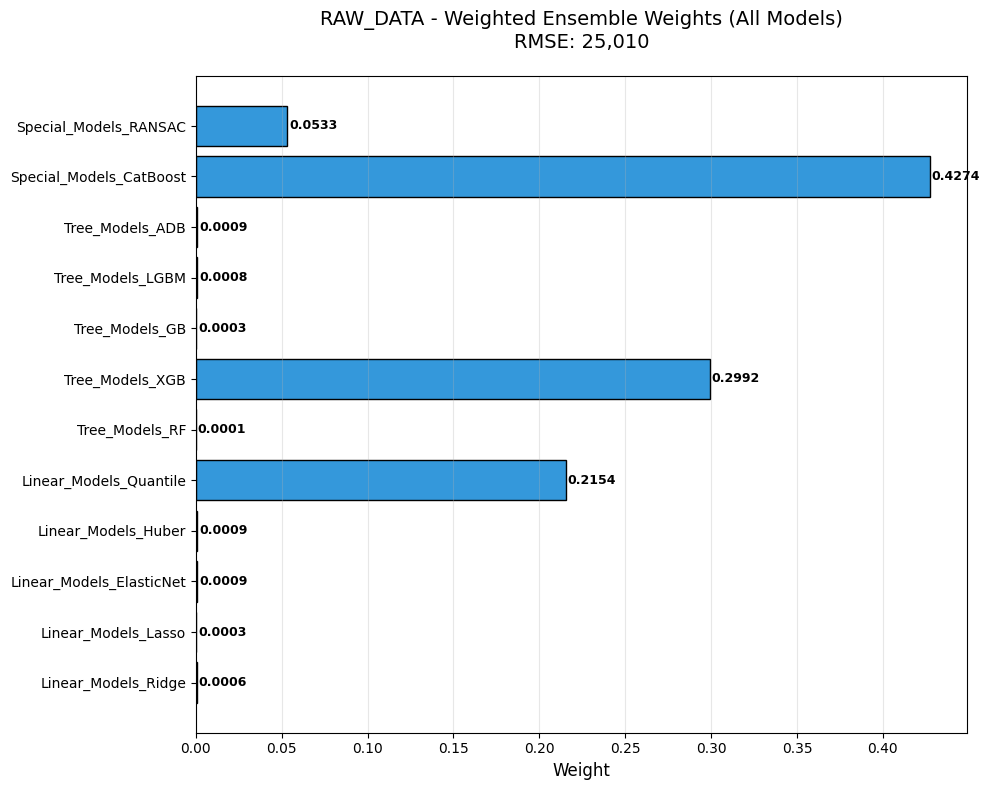

   Đã lưu: results/all_models_analysis/01_weighted_weights_raw_data.png


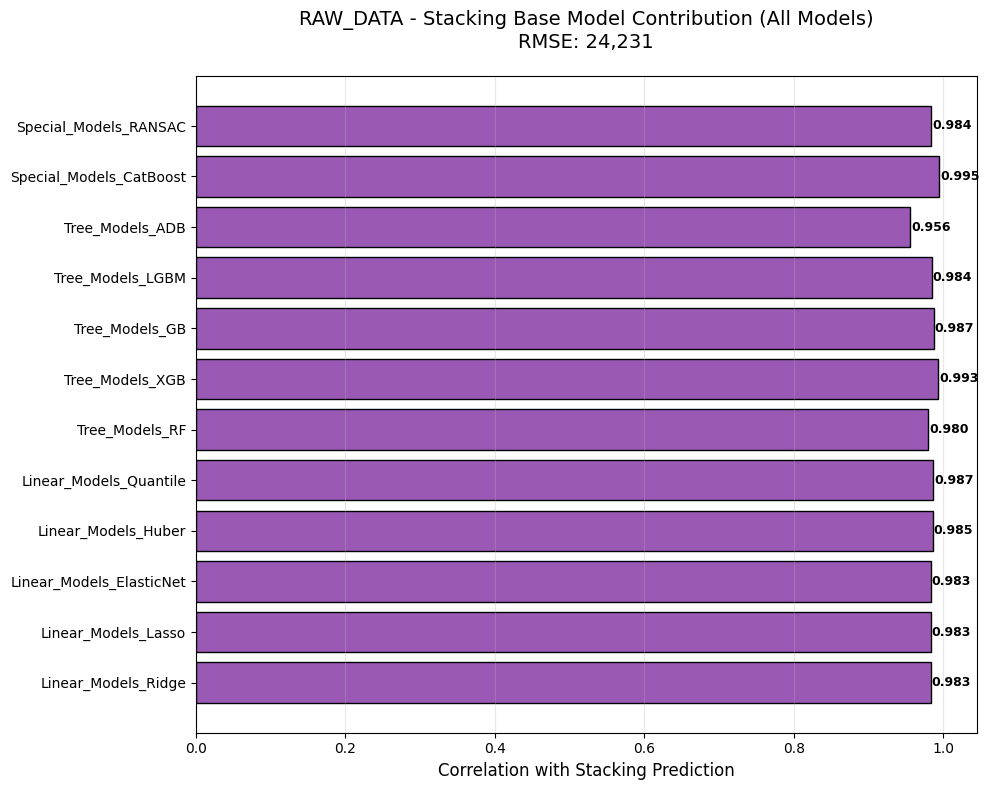

   Đã lưu: results/all_models_analysis/02_stacking_correlation_raw_data.png

TỔNG HỢP ĐÓNG GÓP (ALL MODELS)
                   Model  Weighted_Weight  Stacking_Correlation
     Linear_Models_Ridge           0.0006                0.9829
     Linear_Models_Lasso           0.0003                0.9832
Linear_Models_ElasticNet           0.0009                0.9829
     Linear_Models_Huber           0.0009                0.9854
  Linear_Models_Quantile           0.2154                0.9866
          Tree_Models_RF           0.0001                0.9797
         Tree_Models_XGB           0.2992                0.9931
          Tree_Models_GB           0.0003                0.9867
        Tree_Models_LGBM           0.0008                0.9841
         Tree_Models_ADB           0.0009                0.9558
 Special_Models_CatBoost           0.4274                0.9946
   Special_Models_RANSAC           0.0533                0.9839
   Đã lưu bảng: results/all_models_analysis/contribution_sum

In [ ]:
visualize_all_models_contribution(
    weighted_res=raw_weighted_res,
    stacking_res=raw_stacking_res,
    dataset_name="raw_data",
    save_dir="results/all_models_analysis"
)

### FE Data

**AVERAGING**

In [ ]:
FE_weighted_res, _ = run_optuna_weighted_ensemble(FE_data, "FE_data", base_models, model_groups, config)


→ Running group: Linear_Models
   Training Ridge (target: sqrt)...
      Fold 1 → RMSE=30604.40
      Fold 2 → RMSE=30731.57
      Fold 3 → RMSE=32335.10
      Fold 4 → RMSE=26827.97
      Fold 5 → RMSE=24239.60
   Ridge: Mean RMSE = 28947.73
   Training Lasso (target: sqrt)...
      Fold 1 → RMSE=30921.21
      Fold 2 → RMSE=30411.07
      Fold 3 → RMSE=32456.12
      Fold 4 → RMSE=26588.82
      Fold 5 → RMSE=24050.97
   Lasso: Mean RMSE = 28885.63
   Training ElasticNet (target: sqrt)...
      Fold 1 → RMSE=30594.12
      Fold 2 → RMSE=30730.85
      Fold 3 → RMSE=32343.92
      Fold 4 → RMSE=26823.56
      Fold 5 → RMSE=24235.78
   ElasticNet: Mean RMSE = 28945.65
   Training Huber (target: sqrt)...
      Fold 1 → RMSE=31773.52
      Fold 2 → RMSE=31179.50
      Fold 3 → RMSE=32244.16
      Fold 4 → RMSE=26657.79
      Fold 5 → RMSE=22345.65
   Huber: Mean RMSE = 28840.13
   Training Quantile (target: sqrt)...
      Fold 1 → RMSE=31540.89
      Fold 2 → RMSE=31262.90
      Fold 3 

**STACKING**

In [ ]:
FE_stacking_res, _ = run_stacking_ensemble(FE_data, "FE_data", base_models, model_groups, config)


STACKING - FE_DATA

→ Running group: Linear_Models
   Training Ridge (target: sqrt)...
      Fold 1 → RMSE=30604.40
      Fold 2 → RMSE=30731.57
      Fold 3 → RMSE=32335.10
      Fold 4 → RMSE=26827.97
      Fold 5 → RMSE=24239.60
   Ridge: Mean RMSE = 28947.73
   Training Lasso (target: sqrt)...
      Fold 1 → RMSE=30921.21
      Fold 2 → RMSE=30411.07
      Fold 3 → RMSE=32456.12
      Fold 4 → RMSE=26588.82
      Fold 5 → RMSE=24050.97
   Lasso: Mean RMSE = 28885.63
   Training ElasticNet (target: sqrt)...
      Fold 1 → RMSE=30594.12
      Fold 2 → RMSE=30730.85
      Fold 3 → RMSE=32343.92
      Fold 4 → RMSE=26823.56
      Fold 5 → RMSE=24235.78
   ElasticNet: Mean RMSE = 28945.65
   Training Huber (target: sqrt)...
      Fold 1 → RMSE=31773.52
      Fold 2 → RMSE=31179.50
      Fold 3 → RMSE=32244.16
      Fold 4 → RMSE=26657.79
      Fold 5 → RMSE=22345.65
   Huber: Mean RMSE = 28840.13
   Training Quantile (target: sqrt)...
      Fold 1 → RMSE=31540.89
      Fold 2 → RMSE=31

**COMPARE RESULTS**


SO SÁNH: BEST SINGLE vs WEIGHTED vs STACKING - FE_DATA
           Set  Best_Single_RMSE  Weighted_RMSE  Stacking_RMSE
    all_models          26185.31       26134.16       25771.00
   top4_global          26185.31       26090.07       25917.28
top1_per_group          26185.31       26228.64       25994.49


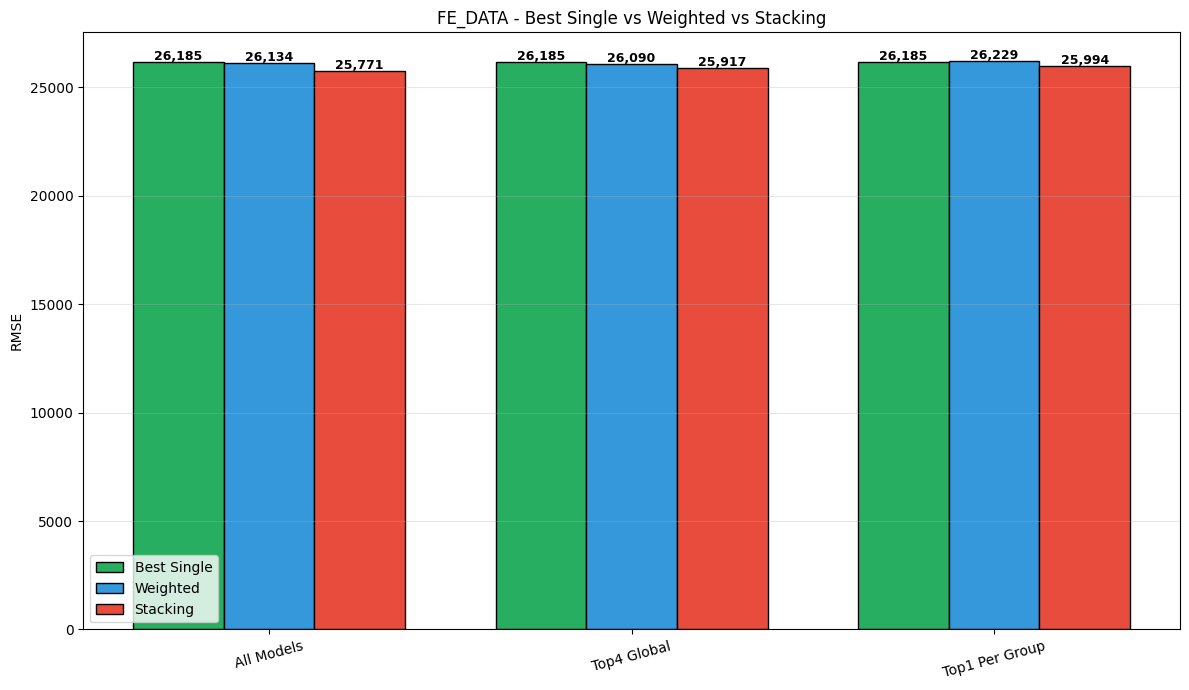

Đã lưu biểu đồ so sánh 3 cột tại:
   results/final_comparison


In [ ]:
compare_ensembles(FE_weighted_res, FE_stacking_res, "FE_data")

### FE FS Data

**AVERAGING**

In [ ]:
FE_FS_weighted_res, _ = run_optuna_weighted_ensemble(FE_FS_data, "FE_FS_data", base_models, model_groups, config)


→ Running group: Linear_Models
   Training Ridge (target: sqrt)...
      Fold 1 → RMSE=32743.38
      Fold 2 → RMSE=30659.47
      Fold 3 → RMSE=32645.19
      Fold 4 → RMSE=27748.04
      Fold 5 → RMSE=22990.75
   Ridge: Mean RMSE = 29357.36
   Training Lasso (target: sqrt)...
      Fold 1 → RMSE=32790.49
      Fold 2 → RMSE=30470.91
      Fold 3 → RMSE=32735.09
      Fold 4 → RMSE=27546.26
      Fold 5 → RMSE=22950.36
   Lasso: Mean RMSE = 29298.62
   Training ElasticNet (target: sqrt)...
      Fold 1 → RMSE=32741.93
      Fold 2 → RMSE=30647.38
      Fold 3 → RMSE=32655.50
      Fold 4 → RMSE=27739.58
      Fold 5 → RMSE=22988.39
   ElasticNet: Mean RMSE = 29354.56
   Training Huber (target: sqrt)...
      Fold 1 → RMSE=33080.09
      Fold 2 → RMSE=31111.09
      Fold 3 → RMSE=32557.77
      Fold 4 → RMSE=27702.71
      Fold 5 → RMSE=22834.83
   Huber: Mean RMSE = 29457.30
   Training Quantile (target: sqrt)...
      Fold 1 → RMSE=33076.18
      Fold 2 → RMSE=31228.58
      Fold 3 

**STACKING**

In [ ]:
FE_FS_stacking_res, _ = run_stacking_ensemble(FE_FS_data, "FE_FS_data", base_models, model_groups, config)


STACKING - FE_FS_DATA

→ Running group: Linear_Models
   Training Ridge (target: sqrt)...
      Fold 1 → RMSE=32743.38
      Fold 2 → RMSE=30659.47
      Fold 3 → RMSE=32645.19
      Fold 4 → RMSE=27748.04
      Fold 5 → RMSE=22990.75
   Ridge: Mean RMSE = 29357.36
   Training Lasso (target: sqrt)...
      Fold 1 → RMSE=32790.49
      Fold 2 → RMSE=30470.91
      Fold 3 → RMSE=32735.09
      Fold 4 → RMSE=27546.26
      Fold 5 → RMSE=22950.36
   Lasso: Mean RMSE = 29298.62
   Training ElasticNet (target: sqrt)...
      Fold 1 → RMSE=32741.93
      Fold 2 → RMSE=30647.38
      Fold 3 → RMSE=32655.50
      Fold 4 → RMSE=27739.58
      Fold 5 → RMSE=22988.39
   ElasticNet: Mean RMSE = 29354.56
   Training Huber (target: sqrt)...
      Fold 1 → RMSE=33080.09
      Fold 2 → RMSE=31111.09
      Fold 3 → RMSE=32557.77
      Fold 4 → RMSE=27702.71
      Fold 5 → RMSE=22834.83
   Huber: Mean RMSE = 29457.30
   Training Quantile (target: sqrt)...
      Fold 1 → RMSE=33076.18
      Fold 2 → RMSE

**COMPARE RESULTS**


SO SÁNH: BEST SINGLE vs WEIGHTED vs STACKING - FE_FS_DATA
           Set  Best_Single_RMSE  Weighted_RMSE  Stacking_RMSE
    all_models          26006.08       25981.89       24966.33
   top4_global          26006.08       25932.91       25734.97
top1_per_group          26006.08       26065.11       25838.54


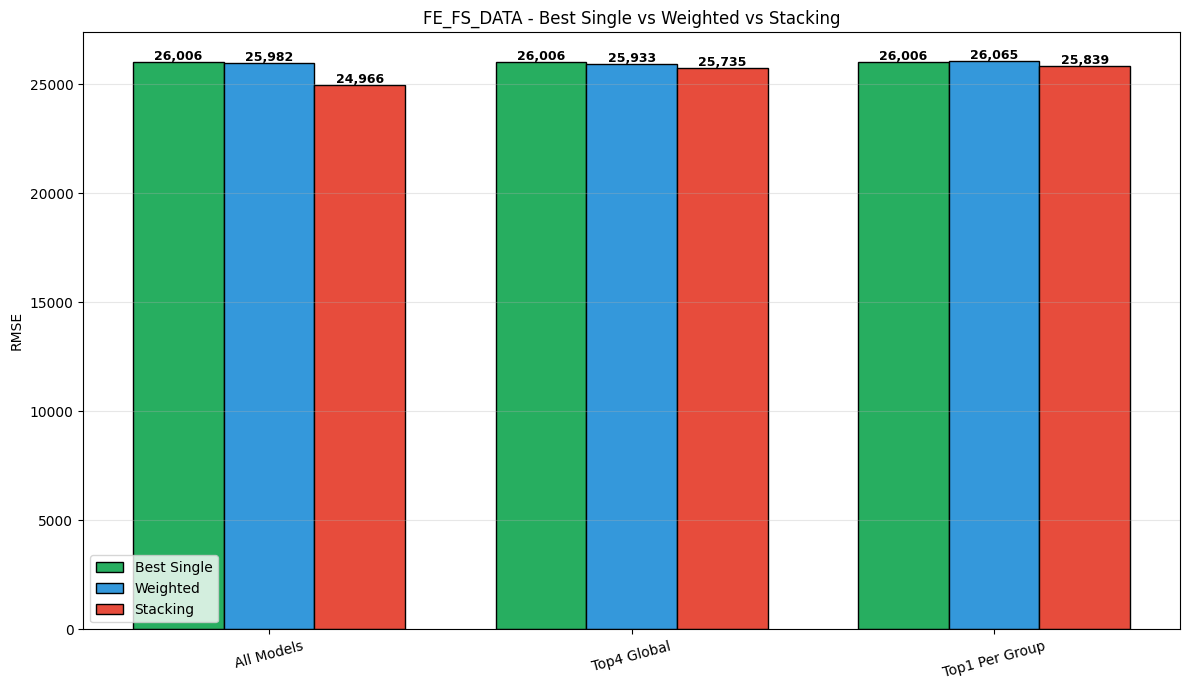

Đã lưu biểu đồ so sánh 3 cột tại:
   results/final_comparison


In [ ]:
compare_ensembles(FE_FS_weighted_res, FE_FS_stacking_res, "FE_FS_data")